In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.collections import PatchCollection
import glob
import copy
import os
from pathlib import Path

from nvita.utils import open_json
from nvita.attacks.utils import (append_result_to_csv_file,
                                 check_result_file_path,
                                 create_empty_result_csv_file)

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up PATH

In [2]:
PATH_ROOT = Path(os.getcwd()).parent.absolute()
PATH_NTRE = os.path.join(PATH_ROOT, "results", "non_targeted_results")
PATH_TARE = os.path.join(PATH_ROOT, "results", "targeted_results")
PATH_EXPS = os.path.join(PATH_ROOT, "experiments")

In [3]:
my_metadata = open_json(os.path.join(
    PATH_ROOT, "experiments", "metadata.json"))
print(my_metadata)

{'data': ['Electricity', 'NZTemp', 'CNYExch', 'Oil'], 'seeds': ['2210', '9999', '58361', '789789', '1111111'], 'y_col_name': ['Consumption', 'Auckland', 'Close', 'Close'], 'window_size': ['4', '3', '7', '7'], 'models': ['CNN', 'LSTM', 'GRU', 'RF'], 'attacks': ['NOATTACK', 'BRS', 'BRNV', 'FGSM', 'BIM', 'NVITA', 'FULLVITA'], 'n_values': [1, 3, 5], 'epsilons': [0.05, 0.1, 0.15, 0.2], 'targets': ['Positive', 'Negative']}


In [4]:
class RequiredCSV:
    """
    Required CSV class
    """
    def __init__(self, df_name = None, seed = None, eps = None, model = None, attack = None, targeted = False, target_direction = None, count = 0):
        self.df_name = df_name
        self.seed = seed
        self.eps = eps
        self.model = model
        self.attack = attack
        self.targeted = targeted
        self.target_direction = target_direction
        self.count = count
        self.all_paths = []
        # all_names list is used to check duplications
    def get_output_line_list(self):
        if self.targeted:
            return [self.df_name, self.seed, self.eps, self.model, self.attack, self.target_direction, self.count, str(self)]
        else:
            return [self.df_name, self.seed, self.eps, self.model, self.attack, self.count, str(self)]
        
    def __str__(self) -> str:
        if self.targeted:
            return "df_"+self.df_name+"_seed_"+str(self.seed)+"_model_"+self.model+"_epsilon_"+str(self.eps)+"_attack_"+self.attack+"_target_"+self.target_direction
        else:
            return "df_"+self.df_name+"_seed_"+str(self.seed)+"_model_"+self.model+"_epsilon_"+str(self.eps)+"_attack_"+self.attack

## Non-targeted Check

In [5]:
nont_d = {}
total_count = 0
for df in my_metadata["data"]:
    for seed in my_metadata["seeds"]:
        for eps in my_metadata["epsilons"]:
            for model in my_metadata["models"]:
                if model == "RF":
                    attacks = ["NOATTACK", "BRS", "Non_Targeted_BR5V", "Non_Targeted_1VITA", "Non_Targeted_3VITA", "Non_Targeted_5VITA", "FULLVITA"]
                else:
                    attacks = ["NOATTACK", "BRS", "Non_Targeted_BR5V", "FGSM", "BIM", "Non_Targeted_1VITA", "Non_Targeted_3VITA", "Non_Targeted_5VITA", "FULLVITA"]
                for attack in attacks:
                    rcsv = RequiredCSV(df, seed, eps, model, attack)
                    total_count += 1
                    nont_d[str(rcsv)] = rcsv
print("Total number of csv result files for non-targeted experiments are " + str(total_count))

Total number of csv result files for non-targeted experiments are 2720


In [6]:
for (root,dirs,files) in os.walk(PATH_NTRE, topdown=True):
    for file in (f for f in files if f.endswith(".csv")):
        file_path = Path(root, file)
        df = pd.read_csv(file_path, index_col=None, header=0)
        if df.shape[0] == 100:
            # Complete result
            suffix_ind = -5
            while file[suffix_ind] == "1":
                suffix_ind -= 1
            nont_d[file[:suffix_ind+1]].count+=1
            nont_d[file[:suffix_ind+1]].all_paths.append(file_path)
            # Append the existing file name, it can be modified to remove duplication

In [7]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap.from_list("", ["lightskyblue","blue"])
cmap_whiteblue = colors.LinearSegmentedColormap.from_list("", ["white","blue"])
cdict = {"1VITA": cmap(0.1),
         "3VITA": cmap(0.45),
         "5VITA": cmap(0.70),
         "fullVITA": cmap(0.99),#"#d7af00",
         "FGSM": "#CC6677",
         "BIM": "#882255",
         "BR5V": "#EECC66",#"#00ff5f",
         "BRS": "#d7af00",#"#00af87",
         "BR5": "#00875f",
         "RFGSM": "#117733",
         "BPM": "#999CC77",
         "BR": "#44AA99",
         "No Attack": "darkgrey"}
all_d_names = ["Electricity", "NZTemp","CNYExch", "Oil"]
order_nont_anns = ["No Attack", "BR5V", "BRS", "1VITA", "3VITA", "5VITA", "fullVITA", "FGSM", "BIM"]

In [8]:
# Generate result check csv
nt_fl = ["df_name", "seed", "eps", "model", "attack", "occurrence", "full_name"]
nt_path = os.path.join(PATH_ROOT, "results", "non_targeted_check_result.csv")
create_empty_result_csv_file(nt_path, nt_fl)
for k in nont_d:
    line_list = nont_d[k].get_output_line_list()
    append_result_to_csv_file(nt_path, line_list)

File C:\Users\markc\Working_Space\nvita_visualization\results\non_targeted_check_result.csv has already existed!


# Non-Targeted Summary Plot

### Read non-targeted data

In [9]:
li = []
result_count = 0
for r in nont_d:
    curr_exp = nont_d[r]
    if curr_exp.count >= 1:
        # if the valid csv file is larger than 1
        file_path = curr_exp.all_paths[0]
        # read the first valid result csv
        df = pd.read_csv(file_path, index_col=None, header=0)
        li.append(df)
        result_count+=1

df_nont = pd.concat(li, axis=0, ignore_index=True)
print("Total number of csv result files for non-targeted experiments are 2720")
print("We currently have", result_count)

Total number of csv result files for non-targeted experiments are 2720
We currently have 2720


In [10]:
df_nont = df_nont[["df","Seed", "Model","Epsilon", "Test Index","Attack Name", "Attacked AE", "Max Per", "Sum Per", "Cost Time"]]
df_nont.rename(columns = {"Max Per":"Max Perturbation", "Sum Per":"Total Perturbation"}, inplace = True)
df_nont["Attack Name"] = df_nont["Attack Name"].map(
    {"NOATTACK": "No Attack", "Non-targeted_1VITA": "1VITA", "Non-targeted_3VITA": "3VITA","Non-targeted_5VITA": "5VITA",
     "Non-targeted_fullVITA": "fullVITA","Non-targeted_FGSM": "FGSM","Non-targeted_BIM": "BIM","Non-targeted_BR5V":"BR5V",
     "Non-targeted_BRS":"BRS"})

In [11]:
df_nont_anns = df_nont[df_nont["Model"] != "RF"]

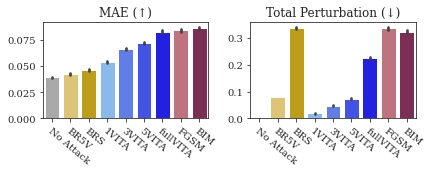

In [12]:
sns.set_style("ticks")
plt.rc("font", family="serif")
f, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharey=False, sharex=False)

g = sns.barplot(palette=cdict, order=order_nont_anns, data=df_nont_anns, x="Attack Name", y="Attacked AE", ax=ax[0])
g.set_xlabel("")
g.set_ylabel("")
g.set_xticklabels(g.get_xticklabels(), rotation = 320, ha="left", rotation_mode="anchor")
g.set_title("MAE (↑)")

g = sns.barplot(palette=cdict, order=order_nont_anns, data=df_nont_anns, x="Attack Name", y="Total Perturbation", ax=ax[1])
g.set_xlabel("")
g.set_ylabel("")
g.set_xticklabels(g.get_xticklabels(), rotation = 320, ha="left", rotation_mode="anchor")
g.set_title("Total Perturbation (↓)")
plt.tight_layout()
plt.savefig("nont_summary.pdf", bbox_inches="tight")

## targeted Check

In [13]:
t_d = {}
total_count = 0
for df in my_metadata["data"]:
    for seed in my_metadata["seeds"]:
        for eps in my_metadata["epsilons"]:
            for td in my_metadata["targets"]:
                for model in my_metadata["models"]:
                    if model == "RF":
                        attacks = ["NOATTACK", "BRS", "Targeted_BR5V", "Targeted_1VITA", "Targeted_3VITA", "Targeted_5VITA", "FULLVITA"]
                    else:
                        attacks = ["NOATTACK", "BRS", "Targeted_BR5V", "FGSM", "BIM", "Targeted_1VITA", "Targeted_3VITA", "Targeted_5VITA", "FULLVITA"]
                    for attack in attacks:
                        rcsv = RequiredCSV(df, seed, eps, model, attack, True, td)
                        total_count += 1
                        t_d[str(rcsv)] = rcsv
print("Total number of csv result files for targeted experiments are " + str(total_count))

Total number of csv result files for targeted experiments are 5440


In [14]:
for (root,dirs,files) in os.walk(PATH_TARE, topdown=True):
    for file in (f for f in files if f.endswith(".csv")):
        file_path = Path(root, file)
        df = pd.read_csv(file_path, index_col=None, header=0)
        if df.shape[0] == 100:
            # Complete result
            suffix_ind = -5
            while file[suffix_ind] == "1":
                suffix_ind -= 1
            t_d[file[:suffix_ind+1]].count+=1
            t_d[file[:suffix_ind+1]].all_paths.append(file_path)
            # Append the existing file name, it can be modified to remove duplication

In [15]:
# order_nont = ["No Attack","BR", "1VITA", "3VITA", "5VITA", "FULLVITA", "FGSM", "BIM"]
# order_t_anns = ["No Attack", "BRS", "1VITA", "3VITA", "5VITA", "fullVITA", "FGSM", "BIM"]
order_t = ["No Attack","BR5V", "BRS", "1VITAt", "3VITAt", "5VITAt", "fullVITAt", "FGSMt", "BIMt"]
cdict_t = {"1VITAt": cdict["1VITA"],
           "3VITAt": cdict["3VITA"],
           "5VITAt": cdict["5VITA"],
           "fullVITAt": cdict["fullVITA"],
           "FGSMt": cdict["FGSM"],
           "BIMt": cdict["BIM"],
           "BR5V": cdict["BR5V"],
           "BRS": cdict["BRS"],
           "No Attack": cdict["No Attack"]}

# Targeted Plots

### Read Targeted Data

In [16]:
# this takes 3 MINUTES on my machine; don"t get impatient :)
li = []
result_count = 0
for r in t_d:
    curr_exp = t_d[r]
    if curr_exp.count >= 1:
        # if the valid csv file is larger than 1
        file_path = curr_exp.all_paths[0]
        # read the first valid result csv
        # convert wide to long table
        df = pd.read_csv(file_path, index_col=None, header=0)
        df = df.melt(id_vars=df.columns[:17].append(df.columns[31:33]), 
                 value_vars=df.columns[17:31].append(df.columns[34:]))
        # split column names into seperate columns
        split = df.variable.str.split("\s")
        df["Result Type"] = [s[0] for s in split]
        df["Direction"] = [s[2][:-2] for s in split]
        df["Confidence Percentile"] = [int(s[2][-2:]) for s in split]

        # filter for the correct direction only
        df[df["Target Direction"] == df["Direction"]]

        # rename attacks into something prettier ;)
        df["Attack Name"] = df["Attack Name"].map(
            {"NOATTACK": "No Attack", "Targeted_1VITA": "1VITAt", "Targeted_3VITA": "3VITAt","Targeted_5VITA": "5VITAt",
             "Targeted_fullVITA": "fullVITAt","Targeted_FGSM": "FGSMt","Targeted_BIM": "BIMt","Targeted_BR5V":"BR5V",
             "Targeted_BRS":"BRS"})
        
        li.append(df)
        result_count+=1

df_t = pd.concat(li, axis=0, ignore_index=True)
print("Total number of csv result files for targeted experiments are 5440")
print("We currently have",result_count)

Total number of csv result files for targeted experiments are 5440
We currently have 5440


### Heatmap: Confidence Intervals

In [17]:
# filter for success, not value
df_success = df_t[df_t["Result Type"] == "Success"]
# Exclude RF here
df_success_tmp = df_success[df_success["Model"] != "RF"]
df_success_tmp = df_success_tmp.groupby(by=["Attack Name", "Confidence Percentile"]).agg({"value": np.mean}).reset_index()
df_success_tmp = df_success_tmp.rename({"Confidence Percentile": "Model Prediction Confidence Percentile"}, axis=1)
piv = df_success_tmp.pivot("Attack Name", "Model Prediction Confidence Percentile", "value")

# sort rows
piv.index = pd.CategoricalIndex(piv.index, categories=order_t)
piv.sort_index(level=0, inplace=True)

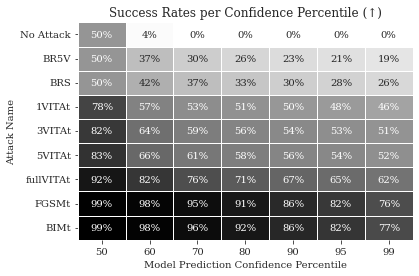

In [18]:
sns.set_style("ticks")
plt.rc("font", family="serif")
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(piv, annot=True, fmt=".0%", linewidths=.5, ax=ax, cmap="Greys", cbar=False)
ax.set_title("Success Rates per Confidence Percentile (↑)")
plt.savefig("t_heatmap_greys.pdf", bbox_inches="tight")

### Classifier Comparison

In [19]:
df_t_small = df_t[["df", "Seed", "Target Direction", "Test Index", "Model","Epsilon","Attack Name","Attacked AE", 
                   "Max Per", "Sum Per"]].copy()
df_t_small.drop_duplicates(inplace=True, ignore_index=True)

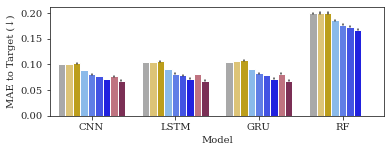

In [20]:
f, ax = plt.subplots(figsize=(6, 2))
g = sns.barplot(palette=cdict_t, hue_order=order_t, ax=ax, errwidth=1.5,
                data=df_t_small, hue="Attack Name", y="Attacked AE", x="Model")
ax.set_ylabel("MAE to Target (↓)")
g.legend_.remove()
#g.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False, ncol=3)
plt.savefig("t_clf_comparison_attack.pdf", bbox_inches="tight")

### New Plot: Attacks vs. Confidence Intervals

In [21]:
df_success = df_t[df_t["Result Type"] == "Success"]
df_success = df_success[df_success["Direction"] == "Positive"]
df_success = df_success[["Attack Name", "Model", "Epsilon", "Confidence Percentile", "df", "value", "Seed", "Test Index"]]

In [22]:
# for each experiment, find the maximum achieved confidence percentile
df_res = df_success.groupby(by=["Attack Name", "Model", "Epsilon", "df", "Seed", "Test Index"]).size().reset_index().drop(0, axis=1)
df_maxper = df_success[df_success["value"] == 1].groupby(
    by=["Attack Name", "Model", "Epsilon", "df", "Seed", "Test Index"]).agg({"Confidence Percentile": np.max}).reset_index()
df_res = df_res.merge(df_maxper, how="left", on=["Attack Name", "Model", "Epsilon", "df", "Seed", "Test Index"])
# if none of the confidence intervals has been achieved, fill in 0
df_res["Confidence Percentile"] = df_res["Confidence Percentile"].fillna(0)

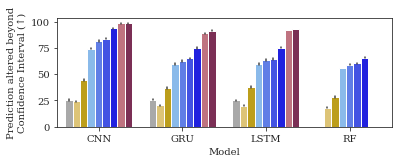

In [23]:
f, ax = plt.subplots(figsize=(6, 2))
g = sns.barplot(palette=cdict_t, hue_order=order_t, errwidth=1.5, ax=ax,
                data=df_res, hue="Attack Name", y="Confidence Percentile", x="Model")
ax.set_ylabel("Prediction altered beyond\nConfidence Interval (↑)")
g.legend_.remove()
#g.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False, ncol=3)
plt.savefig("t_clf_comparison_attack_CI.pdf", bbox_inches="tight")

### Attack vs. Epsilon

In [24]:
# kick out the baselines before averaging over the AE
df_t_attacks = df_t_small[df_t_small["Attack Name"].isin(order_t[3:])]

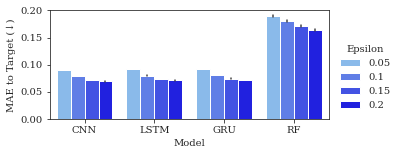

In [25]:
f, ax = plt.subplots(figsize=(5, 2))
g = sns.barplot(ax=ax, errwidth=1.5, palette={0.05: cdict["1VITA"], 0.1: cdict["3VITA"], 0.15: cdict["5VITA"], 0.2: cdict["fullVITA"]},
                data=df_t_attacks, hue="Epsilon", y="Attacked AE", x="Model")
ax.set_ylabel("MAE to Target (↓)")
g.legend(loc="lower left", bbox_to_anchor=(1.01, 0), frameon=False, ncol=1, title="Epsilon")
plt.savefig("t_clf_comparison_epsilon.pdf", bbox_inches="tight")

## Epsilon

In [26]:
# Exclude RF here

df_t_small_anns = df_t_small[df_t_small["Model"] != "RF"]

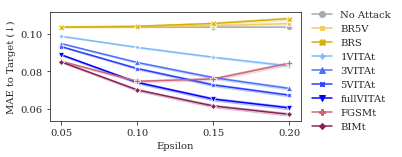

In [27]:
f, ax = plt.subplots(figsize=(4.5, 2))
g = sns.lineplot(palette=cdict_t, hue_order=order_t, ax=ax, style="Attack Name", markers=True, dashes=False,
                data=df_t_small_anns, hue="Attack Name", y="Attacked AE", x="Epsilon")
ax.set_ylabel("MAE to Target (↓)")
ax.set_xticks(df_t_small_anns["Epsilon"].unique())
g.legend(loc="lower left", bbox_to_anchor=(1.01, -0.18), frameon=False, ncol=1)
plt.savefig("t_epsilon.pdf", bbox_inches="tight")

## Trade-Off

In [28]:
# Exclude RF here

df_t_attacks_anns = df_t_attacks[df_t_attacks["Model"] != "RF"]

In [29]:
df_t_attacks_anns_grouped = df_t_attacks_anns.groupby(
    by=["df", "Model", "Epsilon", "Attack Name"]).agg({"Attacked AE": np.mean, "Sum Per": np.mean})

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which 

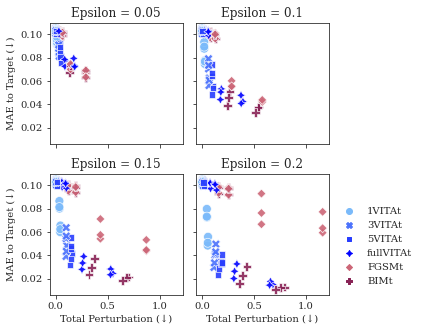

In [30]:
f, ax = plt.subplots(2, 2, figsize=(5, 5), sharey=True, sharex=True)
for i,eps in enumerate(df_t_attacks_anns_grouped.reset_index().Epsilon.unique()):
    g = sns.scatterplot(palette=cdict_t, hue_order=order_t[3:], alpha=0.9, s=80, ax=ax[i//2, i%2],
                        data=df_t_attacks_anns_grouped.reset_index()[df_t_attacks_anns_grouped.reset_index().Epsilon == eps], 
                        hue="Attack Name", y="Attacked AE", x="Sum Per", style="Attack Name", legend=i==3)
    g.set_title("Epsilon = "+str(eps))
    if i//2==1: g.set_xlabel("Total Perturbation (↓)")
    if i%2==0: g.set_ylabel("MAE to Target (↓)")

plt.legend(loc="lower left", bbox_to_anchor=(1.01, 0), frameon=False, ncol=1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.25)
plt.savefig("t_tradeoff_smaller.pdf", bbox_inches="tight")